---
Check that we don't have python 3.10.2 (otherwise PyTorch won't work)

---
Vérifier qu'on n'est pas en 3.10.2 (sinon PyTorch ne marchera pas)

In [1]:
import sys
print(sys.version)

3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]


---
Imports - most importantly clubs_gym (https://github.com/fschlatt/clubs_gym)

In [2]:
import gym
import clubs_gym
from clubs_gym.agent.base import BaseAgent

import time
import random
random.seed(1998)
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

/opt/anaconda3/envs/rl8/lib/python3.8/site-packages/matplotlib_inline/config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


---
List of available environments

In [3]:
clubs_gym.ENVS

['LeducTwoPlayer-v0',
 'KuhnTwoPlayer-v0',
 'KuhnThreePlayer-v0',
 'LimitHoldemTwoPlayer-v0',
 'LimitHoldemSixPlayer-v0',
 'LimitHoldemNinePlayer-v0',
 'NoLimitHoldemTwoPlayer-v0',
 'NoLimitHoldemSixPlayer-v0',
 'NoLimitHoldemNinePlayer-v0',
 'NoLimitHoldemBbAnteNinePlayer-v0',
 'PotLimitOmahaTwoPlayer-v0',
 'PotLimitOmahaSixPlayer-v0',
 'PotLimitOmahaNinePlayer-v0',
 'ShortDeckTwoPlayer-v0',
 'ShortDeckSixPlayer-v0',
 'ShortDeckNinePlayer-v0']

We will only focus on `NoLimitHoldemTwoPlayer-v0` and `NoLimitHoldemSixPlayer-v0`

---
Let's open `NoLimitHoldemTwoPlayer-v0`.

In [4]:
env_str = "NoLimitHoldemTwoPlayer-v0"
num_players = 2  # heads-up
num_streets = 4  # texas hold'em
blinds = [1, 2] 
antes = 0  # a bit weird to have antes in a heads-up I reckon (single ints are expanded to the number of players so could've inputted a list)
raise_sizes = ['inf', 'inf', 'inf', 'inf']  # yes the documentation is wrong, 'inf' should be used and not float('inf')
num_raises = 'inf'  # max number of bets for each street* (including preflop)
num_suits = 4  # number of suits to use in deck (obviously 4 otherwise I mean it's weird)
num_ranks = 13  # same, obviously 13 (A, 2, 3, 4, 5, 6, 7, 8, 9, T, J, Q, K)
num_hole_cards = 2  # **
mandatory_num_hole_cards = 0  # you can use the fives on the board and it will end up being a draw if your enemy does it too
num_community_cards = [0, 3, 1, 1]  # preflop, flop, turn, river
start_stack = 100  
n_cards_for_hand = 5  # texas hold'em
order = ['sf', 'fk', 'fh', 'fl', 'st', 'tk', 'tp', 'pa', 'hc']  # most likely optional, but just to make sure we're working with the right order

config_dict = {'num_players': num_players,
               'num_streets': num_streets,
               'blinds': blinds,
               'antes': antes,
               'raise_sizes': raise_sizes,
               'num_raises': num_raises,
               'num_suits': num_suits,
               'num_ranks': num_ranks,
               'num_hole_cards': num_hole_cards,
               'mandatory_num_hole_cards': mandatory_num_hole_cards,
               'num_community_cards': num_community_cards,
               'start_stack': start_stack,
               'num_cards_for_hand': n_cards_for_hand,
               'order': order}

---
Some vocabulary:
- \* A card that’s dealt in a particular betting round, in many poker variants, is called a **street**. For example, in Texas Hold’em and Omaha, the community cards are referred to as the flop, turn and river, with the turn and river sometimes referred to as Fourth Street and Fifth Street.
- ** The term **hole cards' in poker signals that the cards are private cards that should only be viewed by the player. The dealer deals hole cards face down and players should ensure that the value of those cards remains secret.

---
`obs` is really hard to read, thus we created a `print_obs` function to get nice prints on what is happening.

In [5]:
def print_obs(obs):
    """
    Fancy print of stats for the clubs gym poker gym.
    All Cards displayed (we see everybody's cards)
    
    param: obs: first argument returned by env.step
    return: none
    """
    for _ in range(3):
        print('\n')
    print('------------------- Players\' stacks -------------------')
    print(f"player_0: {obs['stacks'][0]}\n" + \
          f"player_1: {obs['stacks'][1]}")
    print('------------------- Game Stats -------------------')
    print(f'community_cards: {obs["community_cards"]}')
    print(f'Dealer/Button: {obs["button"] % 2}')
    print(f'Pot: {obs["pot"]}')
    print(f'Commits: player_0: {obs["street_commits"][0]} |||  player_1: {obs["street_commits"][1]}')

    if not obs['action'] == -1:
        print(f"\n---------------- player {obs['action']}'s turn ----------------")
        print(f'hole_cards: {obs["hole_cards"]}')
        print(f'call: {obs["call"]}, min_raise: {obs["min_raise"]}, max_raise: {obs["max_raise"]}', end='\n\n')
    else:
        print('\n[INFO] - End of the Game.')

---
# Main

`env.act` handles the agents turns add calls `act` method of agent. All agent require an `act()` method.

`env.step` asks for an integer corresponding to the amount you want to bet. 
- If the bet is less than the minimum bet, you fold. 
- If the bet is higher than the maximum bid (which in Texas Hold'em not limit means that you want to bet more than you have) then you go all-in.

Here, we code three agents : AllInFoldQLearningAgent, RandomAllInFold and HumanRandomAllInFold.

In [6]:
class RandomAllInFold(BaseAgent):
    '''
    This agent bets everyting or folds (50/50 chance).
    '''
    def __init__(self, player_id):
        self.player_id = player_id

    def act(self, info_dict):
        available_chips = info_dict['stacks'][self.player_id]
        draw = random.random()
        if draw >= 0.5:  # >= and not > because random.random() returns random floating point number in the range [0.0, 1.0)
            action = 1 
        else:
            action = 0

        ## outpu  
        if action == 0:
            return(0)
        else:
            return(available_chips)

In [7]:
class HumanRandomAllInFold(BaseAgent):
    """
    The human can choose between two actions, all in or fold.
    """
    def __init__(self, player_id):
        self.player_id = player_id

    def act(self, info_dict):
        available_chips = info_dict['stacks'][self.player_id]
        
        action = -1
        while action != 0 and action != 1:
            action = int(input("Do you want to push (1) or fold (0)?"))
            
        if action == 0:
            return(0)
        else:
            return(available_chips)

In [8]:
class AllInFoldQLearningAgent(BaseAgent):
    """
    Model-free reinforcement learning algorithm to learn the value of an action (called here agent_decision, cf. below) 
    in a particular state (here 2 hole cards).
    agent_decision:
        - 0: folds
        - 1: all-in
    We call decision the usual term action because the library clubs_gym uses action to determine whose next to play. So, to avoid
    any confusion, action will be reserved to the use clubs_gym makes it of.
    """
    
    
    def __init__(self, player_id, agent_init_info):
        self.player_id = player_id

        self.state_size = agent_init_info["state_size"]  # size of the iterable state
        self.num_agent_decision = agent_init_info["num_agent_decision"]  # how many decisions can the agent make
        self.epsilon = agent_init_info["epsilon"]  # exploration, got to be set to 0 after training when we want an "optimal" agent
        
        self.q = {}  # policy the agent is learning
        
        self.step_size_initial = agent_init_info["step_size"]
        
        if self.step_size_initial:
            # If step_size is fixed
            self.step_size = agent_init_info["step_size"]
        else:
            # The step-size is then 1/N(A), where N(A) is the number of times action A was selected. 
            # This is the same as computing a sample average.
            self.count = {}  # number of times a given decision has been made in a particular state
        
        self.discount = agent_init_info["discount"]  # gamma
        
        self.has_already_made_a_decision = False 


    def agent_start(self, state):
        # Chooses action using epsilon greedy.
        self.has_already_made_a_decision = True

        tuple_representing_state = (str(state[0]), str(state[1]))
        self.q.setdefault(tuple_representing_state, [0]*self.num_agent_decision)  # a 0 for fold and a 0 for all-i
        # we don't need self.count because we don't update the q values
        # but we need self.q to make the decisions
        
        if random.random() < self.epsilon:
            agent_decision = random.randint(0, self.num_agent_decision-1)  # random decision selection
        else:
            agent_decision = self.argmax(self.q[tuple_representing_state])  # greedy decision selection
        self.prev_state = tuple_representing_state
        self.prev_agent_decision = agent_decision
        return agent_decision
    
    
    def agent_step(self, reward, state):
        # Chooses action using epsilon greedy.
        # Updates self.q
        
        tuple_representing_state = (str(state[0]), str(state[1]))
        if not self.step_size_initial:
            self.count.setdefault(self.prev_state, [0]*self.num_agent_decision)
            self.count[self.prev_state][self.prev_agent_decision] += 1
            self.step_size = 1/self.count[self.prev_state][self.prev_agent_decision]
        self.q.setdefault(tuple_representing_state, [0]*self.num_agent_decision) # a 0 for fold and a 0 for all-i
        
        if random.random() < self.epsilon:
            agent_decision = random.randint(0, self.num_agent_decision-1)  # random decision selection
        else:
            agent_decision = self.argmax(self.q[tuple_representing_state])  # greedy decision selection
        
        previous_estimates_list = self.q[self.prev_state]
        previous_estimates_list[self.prev_agent_decision] += \
            self.step_size*(reward + self.discount * np.max(self.q[tuple_representing_state]) - self.q[self.prev_state][self.prev_agent_decision])
        self.q[self.prev_state] = previous_estimates_list
        
        self.prev_state = tuple_representing_state
        self.prev_agent_decision = agent_decision
        return agent_decision
    
    
    def agent_end(self, reward):
        # Updates self.q
        if self.has_already_made_a_decision:  
            # sometimes, the end is reached before the agent has had to make any decision. This typically happens when
            # the agent is the Big Blind and everyone folds. In this case, you haven't made any decision so you can't really
            # infer anything about the strength of your hand.
            if not self.step_size_initial:
                self.count.setdefault(self.prev_state, [0]*self.num_agent_decision)
                self.count[self.prev_state][self.prev_agent_decision] += 1
                self.step_size = 1/self.count[self.prev_state][self.prev_agent_decision]
            self.q.setdefault(self.prev_state, [0]*self.num_agent_decision)  # a 0 for fold and a 0 for all-i
            previous_estimates_list = self.q[self.prev_state]
            previous_estimates_list[self.prev_agent_decision] += self.step_size*(reward + self.discount * 0 - self.q[self.prev_state][self.prev_agent_decision])
            self.q[self.prev_state] = previous_estimates_list



    def act(self, info_dict):
        reward = info_dict['rewards'][self.player_id]
        state = info_dict['state']
        number_of_chips = info_dict['stacks'][self.player_id]
        

        if not self.has_already_made_a_decision:
            agent_decision = self.agent_start(state)

        elif self.has_already_made_a_decision:
            agent_decision = self.agent_step(reward, state)

        if agent_decision == 0:
            return(0)
        elif agent_decision == 1:
            return(number_of_chips)
        else:
            print(f"Error on variable agent_decision (is equal to {agent_decision} which is illegal)")
        
        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return random.choice(ties)

    
    def epsilon_decay(self):
        self.epsilon = self.epsilon * 0.99

        
    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'wb'))
        return(obj)

Epsilon parameters playaround

In [9]:
epsilon_depart = 1
num_episodes = 1000000

print(f"Epsilon goes from {epsilon_depart} up to {1*0.99**(num_episodes/100)}")
print("\n")

Epsilon goes from 1 up to 2.2487748498162805e-44




Trainings of the different Agents against the RandomAllInFold Agent

The different agents only learn to be on one side of the game (reset_button = True !), and here, we learn the small blind (0) strategy then the big bling (1) strategy.

In [10]:
agents_finaux = [[], []]
stacks_a_la_fin_finaux = [[], []]
for big_blind_agent in [0, 1]:
    print(f"The agent is big_blind : {big_blind_agent == 1}")
    for i, step_size in enumerate([False, 0.01, 0.1]):
        print(f"Step_size = {step_size}")
        clubs_gym.envs.register({env_str: config_dict})
        env = gym.make(env_str)
        q_learning_agent_info = {"state_size": 2, "num_agent_decision": 2 , "epsilon": 1, "step_size": step_size, "discount": 1.0}
        if big_blind_agent:  # 1
            agents = [RandomAllInFold(0), AllInFoldQLearningAgent(1, q_learning_agent_info)]
        else:  # 0
            agents = [AllInFoldQLearningAgent(0, q_learning_agent_info), RandomAllInFold(1)]
        env.register_agents(agents)

        # Start the game
        stacks_a_la_fin = []  # in order to plot the evolution of stack_size in the end
        for episodes in tqdm(range(num_episodes), position = 0):
            obs = env.reset(reset_stacks = True, reset_button = True)

            # create a dict containing all necessary info for q learning agent
            info_dict = {}
            info_dict['rewards'] = [0, 0]
            info_dict['state'] = obs['hole_cards']
            info_dict['stacks'] = obs['stacks']

            while True:
                bet = env.act(info_dict)
                obs, rewards, done, info = env.step(bet)  
                # update dict
                info_dict = {}
                info_dict['rewards'] = rewards
                info_dict['state'] = obs['hole_cards']
                info_dict['stacks'] = obs['stacks']


                # print_obs(obs)
                if all(done):
                    stacks_a_la_fin.append(obs['stacks'])
                    agents[big_blind_agent].agent_end(rewards[big_blind_agent])
                    # agents[1].agent_end(rewards[1])

                    if episodes % 100 == 0:
                        agents[big_blind_agent].epsilon_decay()
                    break
        stacks_a_la_fin_finaux[big_blind_agent].append(stacks_a_la_fin)
        agents_finaux[big_blind_agent].append(agents[big_blind_agent])
        env.close()

    print("\n")

100%|██████████| 1000000/1000000 [07:37<00:00, 2187.46it/s]


Step_size = 0.1


100%|██████████| 1000000/1000000 [05:23<00:00, 3095.58it/s]

To get an idea of the value of `stacks_a_la_fin_finaux` in the end:

In [11]:
prints_activate = False

if prints_activate:
    print(len(stacks_a_la_fin_finaux)) # one for SB agent and one for BB agent 
    print(len(stacks_a_la_fin_finaux[0]))  # one per step_size
    print(len(stacks_a_la_fin_finaux[0][0]))  # How many hands there have been
    print(len(stacks_a_la_fin_finaux[0][0][0]))  # Stack player_0, stack player_1 t the end of the 0th hand

print("\n")

Some examples of the policy of the agent on the worst and best hands

In [13]:
for big_blind_agent in [0, 1]:
    print(f"The agent is big blind : {big_blind_agent == 1}")
    for agent in agents_finaux[big_blind_agent]:
        print(f"Agent with step_size = {agent.step_size_initial}")
        if not agent.step_size_initial:
            for mains_preflop in [('A♥', 'A♦'), ('A♥', 'A♣'), ('A♥', 'A♠'), ('2♥', '7♦'), ('2♥', '7♣'), ('2♥', '7♠')]:
                print(f"{mains_preflop}: {agent.q[mains_preflop]}. The hand has been played {agent.count[mains_preflop]} times")
        else:
            for mains_preflop in [('A♥', 'A♦'), ('A♥', 'A♣'), ('A♥', 'A♠'), ('2♥', '7♦'), ('2♥', '7♣'), ('2♥', '7♠')]:
                print(f"{mains_preflop}: {agent.q[mains_preflop]}.")
        print("\n")

The agent is big blind : False
Agent with step_size = False
('A♥', 'A♦'): [-0.18068495008680557, 19.274983054870432]. The hand has been played [8, 810] times
('A♥', 'A♣'): [0, 21.601172782540893]. The hand has been played [0, 772] times
('A♥', 'A♠'): [12.984867160454204, 19.047207123824414]. The hand has been played [6, 740] times
('2♥', '7♦'): [1.337278713679397, -26.195312500000004]. The hand has been played [720, 6] times
('2♥', '7♣'): [1.189405826367422, -14.292945831843255]. The hand has been played [760, 6] times
('2♥', '7♠'): [1.220450655435427, -12.0]. The hand has been played [760, 4] times


Agent with step_size = 0.01
('A♥', 'A♦'): [0.0011433049368985999, 20.923876304273538].
('A♥', 'A♣'): [-0.027686075662878992, 17.002899377891165].
('A♥', 'A♠'): [-0.0100920319457059, 12.499144695161528].
('2♥', '7♦'): [-0.2085300547367384, -1.0193827865273217].
('2♥', '7♣'): [-0.1437684711016665, -0.936112204967784].
('2♥', '7♠'): [-0.08587768819126082, -0.9057223101010391].


Agent with s

Comparison of the average stacks at the end for player 0 (Agent Q-learning) and player 1 (Agent Random), keep in mind that calling the method epsilon_decay() makes it so that the player 0 (Agent Q-learning) explores less and less the environment.

Differents step_size values:
- Q-learning Agent 1: step_size = False
- Q-learning Agent 2: step_size = 0.1
- Q-learning Agent 3: step_size = 0.01

One generation = num_episodes/generation_div

The agent is big blind : False


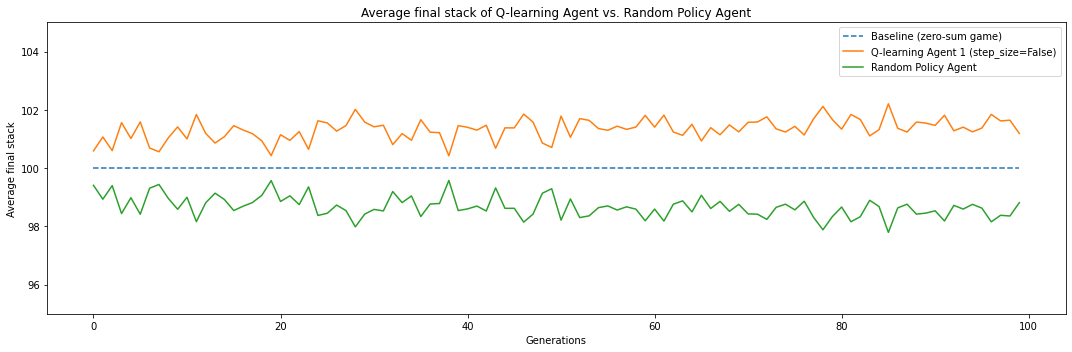

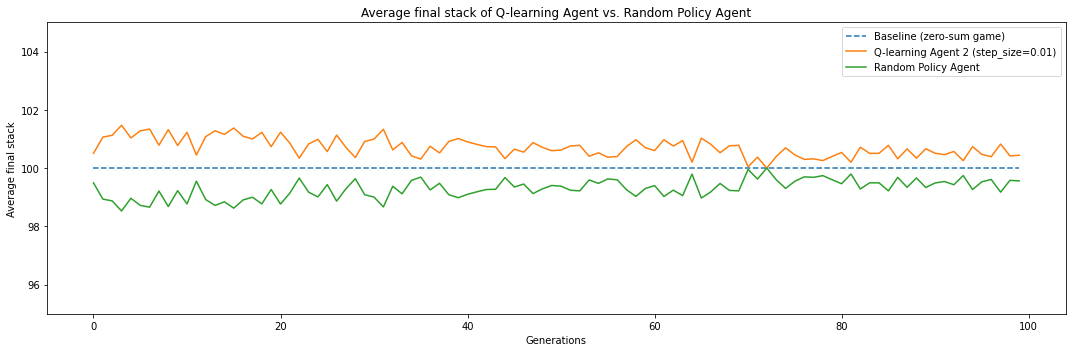

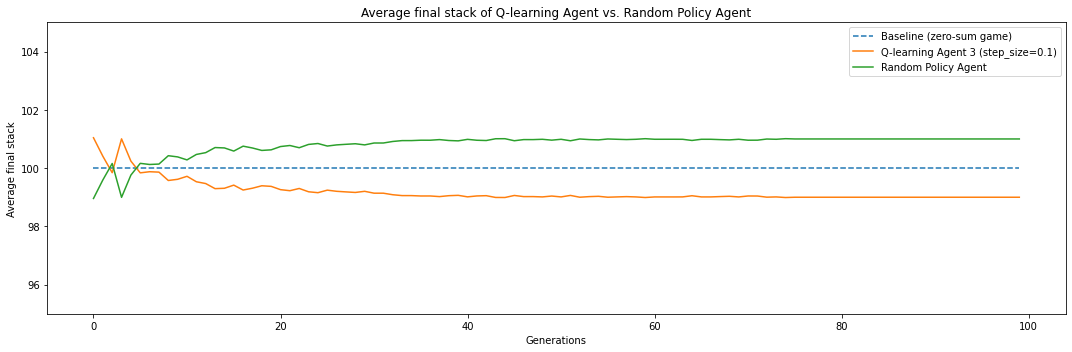

The agent is big blind : True


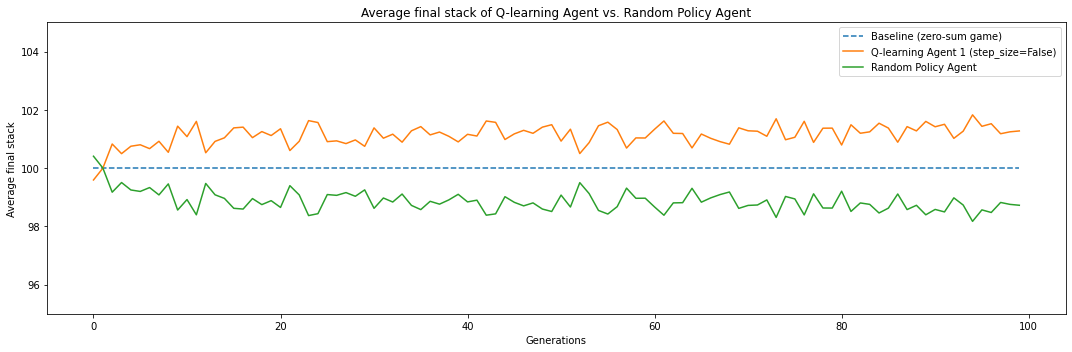

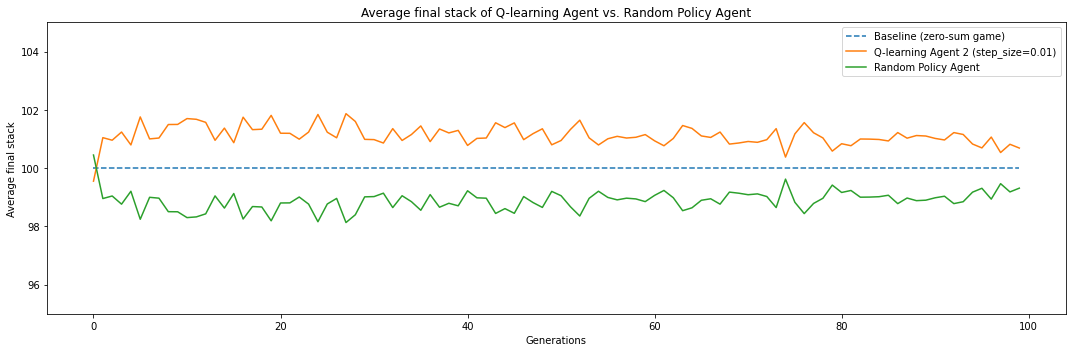

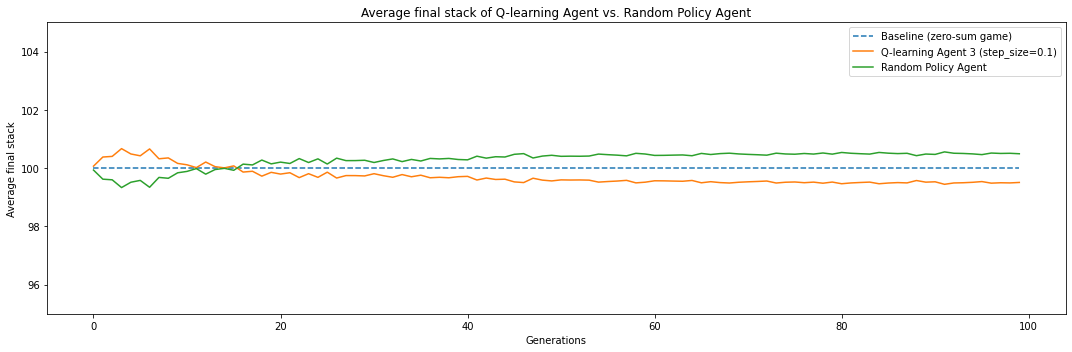

In [14]:
generation = 100

display_text = False

for big_blind_agent in [0, 1]:
    print(f"The agent is big blind : {big_blind_agent == 1}")
    average_per_generation_player_0 = [[], [], []]   # list of list of size int(3 * num_episodes/100 + 1)
    average_per_generation_player_1 = [[], [], []]  # list of size int(3 * num_episodes/100 + 1)
    for i, agent in enumerate(agents_finaux[big_blind_agent]):
        for tranche in range(0, generation):
            # not optimal in terms of complexity but list comprehension look nice
            tranche = tranche/generation
            first_episode_tranche = int(tranche*num_episodes)
            last_episode_tranche = int((tranche+1/generation)*num_episodes)
            if display_text:
                print(f"Episodes {first_episode_tranche} to {last_episode_tranche-1}")
            liste_stacks_a_la_fin_player_0 = [x[0] for x in stacks_a_la_fin_finaux[big_blind_agent][i][first_episode_tranche:last_episode_tranche]]
            average_per_generation_player_0[i].append(np.mean(liste_stacks_a_la_fin_player_0))
            liste_stacks_a_la_fin_player_1 = [x[1] for x in stacks_a_la_fin_finaux[big_blind_agent][i][first_episode_tranche:last_episode_tranche]]
            average_per_generation_player_1[i].append(np.mean(liste_stacks_a_la_fin_player_1))
            if display_text:
                print(f"Agent 0: {round(np.mean(liste_stacks_a_la_fin_player_0), 2)} vs agent 1: {round(np.mean(liste_stacks_a_la_fin_player_1), 2)}")

    display_plot = True
    if display_plot:
        agents_legendes = ["Q-learning Agent 1 (step_size=False)", "Q-learning Agent 2 (step_size=0.01)", "Q-learning Agent 3 (step_size=0.1)"]
        for i in range(0, 3):
            plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
            plt.plot([100 for _ in range(len(average_per_generation_player_0[0]))], linestyle="--")
            if big_blind_agent:  # if the agent is big_blind i.e if the agent is player 1 i.e if the random policy agent is player 0
                plt.plot(average_per_generation_player_1[i])
                plt.plot(average_per_generation_player_0[i])
            else:
                plt.plot(average_per_generation_player_0[i])
                plt.plot(average_per_generation_player_1[i])
            plt.title("Average final stack of Q-learning Agent vs. Random Policy Agent")
            plt.legend(("Baseline (zero-sum game)", agents_legendes[i], "Random Policy Agent"))
            plt.xlabel("Generations")
            plt.ylabel("Average final stack")
            ax = plt.gca()
            ax.set_ylim([95, 105])
            plt.tight_layout()
            if big_blind_agent:
                plt.savefig('big_blind_{}.png'.format(agents_legendes[i]))
            else:
                plt.savefig('small_blind_{}.png'.format(agents_legendes[i]))
            plt.show()

The last agent (the one with a big step size of 0.1) can get stuck into a bad local minimum since it gives too much importantce to the last hands and explores less and less, thus if it gets unlucky several times with AA for instance, it will only fold and will always lose.